In [43]:
# basics
import pandas as pd
import numpy as np

# vectorizer, classifiers, and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, jaccard_score, hamming_loss, log_loss
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.multiclass import OneVsRestClassifier

# rnn
import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.callbacks import EarlyStopping

# custom functions, class to import and process data
from get_labeled_dfs import *
from process_text import *

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, emotion_df, valence_df = get_labeled_dfs()


In [3]:
# use custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)

In [4]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [6]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,15,38,9,11,joy,0,0,1,1,1,1
1,24,26,16,13,38,5,sadness,1,1,1,1,1,1
2,0,0,0,17,0,4,joy,0,0,0,1,0,1
3,0,0,0,46,0,31,joy,0,0,0,1,0,1
4,1,0,23,8,11,8,fear,1,0,1,1,1,1


## Prepare Multilabel Classification Evaluation

To evaluate a model's performance on individual labels, I look at a confusion matrix and accuracy, precision, recall, and f1 scores.

Accuracy

Precision

Recall

F1

Confusion matrix

To evaluate a model's overall performance, I look at jaccard similarity, hamming loss, f1 micro, and log loss.

Jaccard Similarity

Hamming Loss

F1 Micro

Log Loss

In [7]:
def label_confusion_matrices(lst, df, RNN=False):
    
    '''A function that creates confusion matrices and calculates accuracy, precision, 
    recall, and f1 for each individual label'''
    
    plt.figure(figsize=(15,20))
    subplot_num = 1

    for i in lst:
        
        if RNN==False:
        
            tp = len(df.loc[(df['pred_' + i]==1) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]==1) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]==0) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]==0) & (df[i]==0)])
        
        else:
            
            tp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==1)])
            fp = len(df.loc[(df['pred_' + i]>=0.5) & (df[i]==0)])
            fn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==1)])
            tn = len(df.loc[(df['pred_' + i]<0.5) & (df[i]==0)])
        
        
        plt.subplot(3,2,subplot_num)
        sns.heatmap([[tp, fp], [tn, fn]], square=True, annot=True, fmt='g', yticklabels=[i, 'not ' + i], xticklabels=[i, 'not ' + i])
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(i.capitalize() + ' Confusion Matrix')
        subplot_num+=1
        
        accuracy = tp/(fp + tn + tp)
        precision = tp/(fp + tp)
        recall = tp/(tp + fn)
        f1 = 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn))))
        
        print(i + " accuracy:", accuracy)
        print(i + " precision:", precision)
        print(i + " recall", recall)
        print(i + " f1", 2 * (((tp/(fp + tp)) * (tp/(tp + fn))) / ((tp/(fp + tp)) + (tp/(tp + fn)))))
        print('\n')

        

In [8]:
def suite_of_scores(y_true, y_pred):
    
    '''A function that calculates jaccard similarity, hamming loss, f1 macro, 
    and log loss to assess the model's overall performance'''
    
    jaccard_score_samples = jaccard_score(y_true, y_pred, average='samples')
    hamming_loss_score = hamming_loss(y_true, y_pred)
    f1_macro_score = f1_score(y_true, y_pred, average='macro')
    log_loss_score = log_loss(y_true, y_pred)
    
    print('jaccard score average:', round(jaccard_score_samples, 3))
    print('hamming loss:', round(hamming_loss_score, 3))
    print('f1 macro:', round(f1_macro_score, 3))
    print('log loss', round(log_loss_score, 3))

## Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(corpus_df['text'], emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], random_state=3)


## One Versus Rest with LR

I start with a one versus rest model

One versus rest models treat labels as independent

In [10]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_test


<313x2332 sparse matrix of type '<class 'numpy.float64'>'
	with 1138 stored elements in Compressed Sparse Row format>

In [11]:
lr = LogisticRegression(C=1e10, class_weight='balanced')

ovr = OneVsRestClassifier(lr)

ovr.fit(tf_idf_X_train, y_train)
ovr_train_preds = ovr.predict(tf_idf_X_train)
ovr_test_preds = ovr.predict(tf_idf_X_test)

In [14]:
ovr_preds_df = pd.DataFrame(ovr_test_preds, columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
ovr_preds_df = pd.concat([ovr_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4981949458483754
anger_label precision: 0.8117647058823529
anger_label recall 0.7931034482758621
anger_label f1 0.8023255813953488


disgust_label accuracy: 0.33203125
disgust_label precision: 0.6390977443609023
disgust_label recall 0.5985915492957746
disgust_label f1 0.6181818181818183


fear_label accuracy: 0.6389891696750902
fear_label precision: 0.8009049773755657
fear_label recall 0.8309859154929577
fear_label f1 0.815668202764977


joy_label accuracy: 0.5384615384615384
joy_label precision: 0.7368421052631579
joy_label recall 0.7253886010362695
joy_label f1 0.7310704960835509


sadness_label accuracy: 0.6819787985865724
sadness_label precision: 0.8109243697478992
sadness_label recall 0.8654708520179372
sadness_label f1 0.8373101952277657


surprise_label accuracy: 0.8900343642611683
surprise_label precision: 0.9184397163120568
surprise_label recall 0.9217081850533808
surprise_label f1 0.9200710479573712




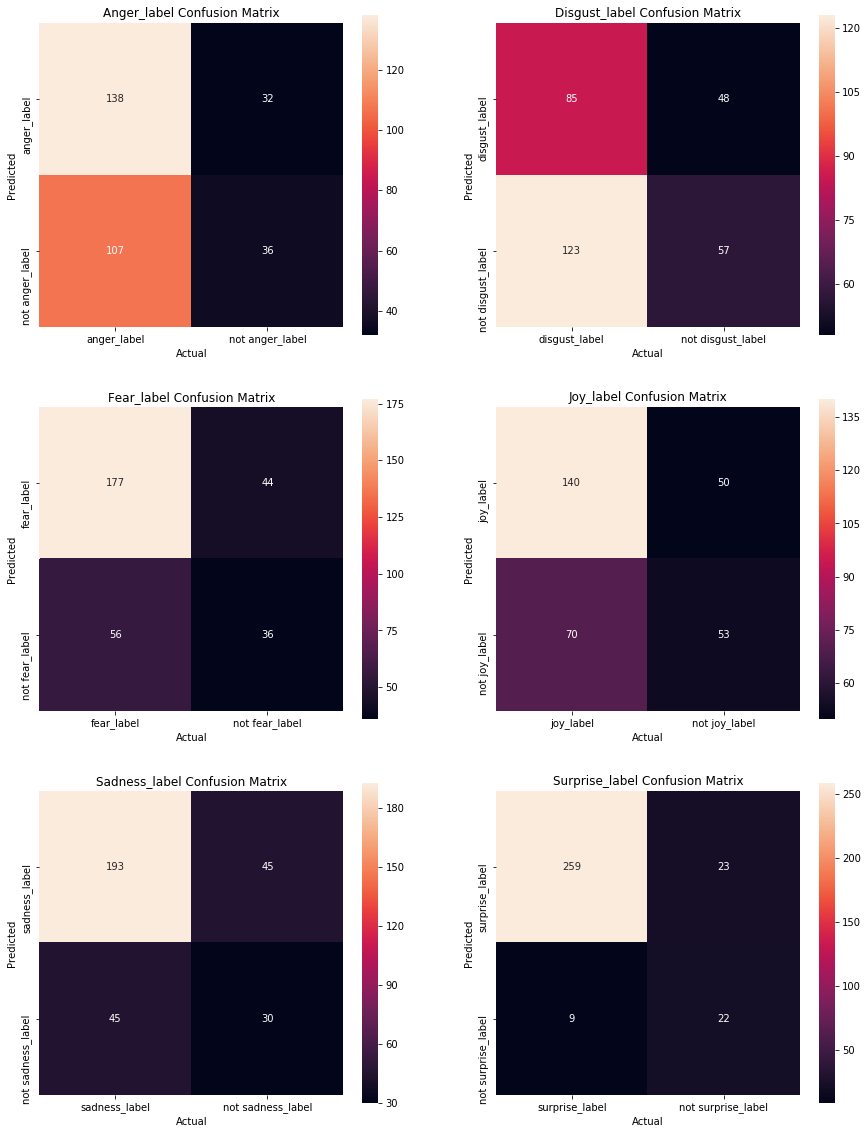

In [20]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], ovr_preds_df)


In [21]:
suite_of_scores(y_test, ovr_test_preds)


jaccard score average: 0.685
hamming loss: 0.253
f1 macro: 0.787
log loss 31.164


## Classifier Chain

In [22]:
import itertools
from sklearn.metrics import jaccard_score

np.random.seed=42
perms = list(itertools.permutations([0,1,2,3,4,5]))
random = np.random.choice(len(perms), size=720,)
perms_to_try = [perms[i] for i in random]

chains = [ClassifierChain(lr, order=perms_to_try[i]) for i in range(720)]

results_jaccard = []
preds = []
for chain in chains:
    chain.fit(tf_idf_X_train, y_train)
    test_preds = chain.predict(tf_idf_X_test)
    preds.append(test_preds)
    results_jaccard.append(jaccard_score(y_test, test_preds, average='samples'))


In [23]:
cc_test_preds = preds[results_jaccard.index(max(results_jaccard))]
max(results_jaccard)

0.6832800851970181

In [24]:
cc_preds_df = pd.DataFrame(cc_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
#y _reindex = y_test.reset_index(drop=True)
cc_preds_df = pd.concat([cc_preds_df, y_reindex], axis=1)

anger_label accuracy: 0.4981949458483754
anger_label precision: 0.8117647058823529
anger_label recall 0.7931034482758621
anger_label f1 0.8023255813953488


disgust_label accuracy: 0.35471698113207545
disgust_label precision: 0.6666666666666666
disgust_label recall 0.6619718309859155
disgust_label f1 0.6643109540636043


fear_label accuracy: 0.6389891696750902
fear_label precision: 0.7972972972972973
fear_label recall 0.8309859154929577
fear_label f1 0.8137931034482759


joy_label accuracy: 0.5402298850574713
joy_label precision: 0.7421052631578947
joy_label recall 0.7305699481865285
joy_label f1 0.7362924281984334


sadness_label accuracy: 0.6629213483146067
sadness_label precision: 0.84688995215311
sadness_label recall 0.7937219730941704
sadness_label f1 0.8194444444444444


surprise_label accuracy: 0.8861209964412812
surprise_label precision: 0.9120879120879121
surprise_label recall 0.8861209964412812
surprise_label f1 0.8989169675090253




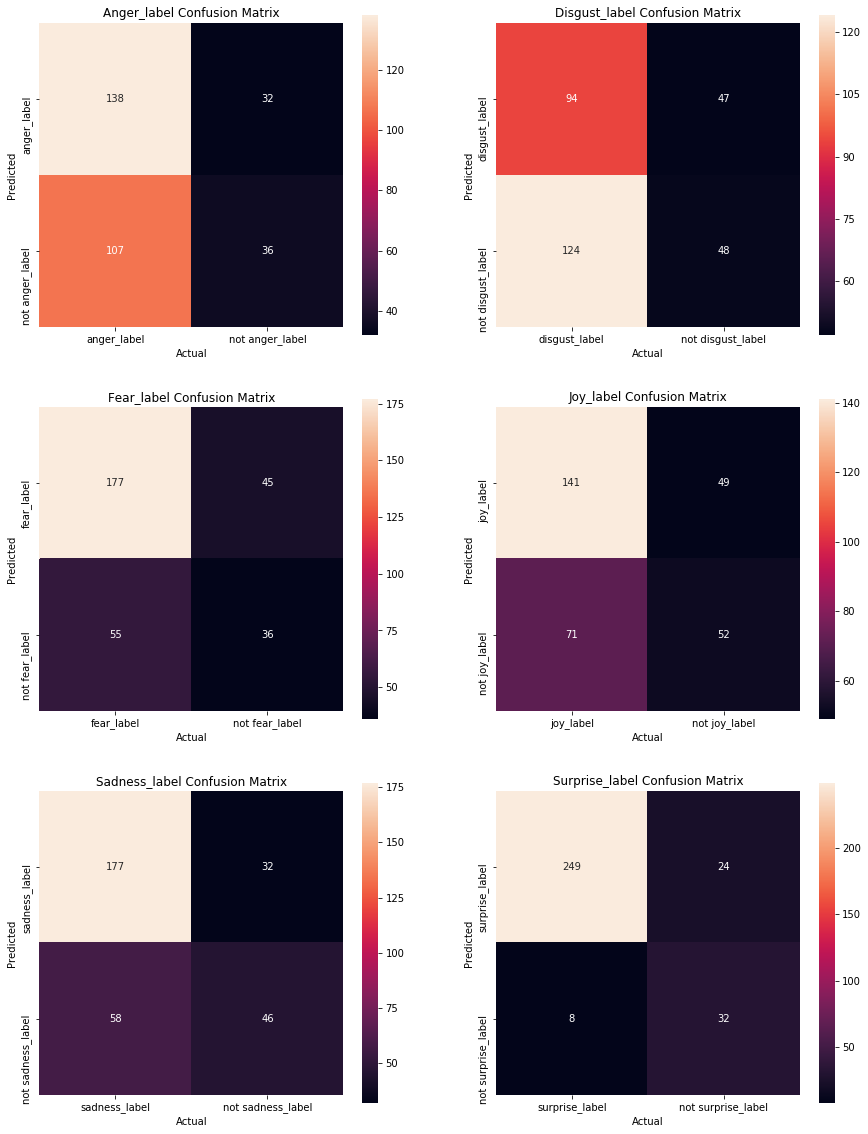

In [25]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], cc_preds_df)



In [26]:
suite_of_scores(y_test, cc_test_preds.toarray())


jaccard score average: 0.683
hamming loss: 0.255
f1 macro: 0.789
log loss 32.777


## Label Powerset Emotion Labels

In [27]:
lp = LabelPowerset(lr)

lp.fit(tf_idf_X_train, y_train)
lp_train_preds = lp.predict(tf_idf_X_train)
lp_test_preds = lp.predict(tf_idf_X_test)

In [28]:
LP_preds_df = pd.DataFrame(lp_test_preds.toarray(), columns=['pred_anger_label', 'pred_disgust_label', 'pred_fear_label', 'pred_joy_label', 'pred_sadness_label', 'pred_surprise_label'])
# y_reindex = y_test.reset_index(drop=True)
LP_preds_df = pd.concat([LP_preds_df, y_reindex], axis=1)


In [29]:
LP_preds_df.head()

,pred_anger_label,pred_disgust_label,pred_fear_label,pred_joy_label,pred_sadness_label,pred_surprise_label,anger_label,disgust_label,fear_label,joy_label,sadness_label,surprise_label
0,0,0,0,1,0,1,0,0,1,1,1,1
1,1,1,1,0,1,1,0,0,1,1,1,1
2,0,0,0,1,0,1,0,0,1,0,1,1
3,0,0,0,1,0,1,0,1,1,0,0,1
4,1,1,1,0,1,1,1,1,1,1,1,1


anger_label accuracy: 0.4889705882352941
anger_label precision: 0.7732558139534884
anger_label recall 0.764367816091954
anger_label f1 0.7687861271676302


disgust_label accuracy: 0.3522727272727273
disgust_label precision: 0.6642857142857143
disgust_label recall 0.6549295774647887
disgust_label f1 0.6595744680851063


fear_label accuracy: 0.6376811594202898
fear_label precision: 0.8461538461538461
fear_label recall 0.8262910798122066
fear_label f1 0.836104513064133


joy_label accuracy: 0.5419847328244275
joy_label precision: 0.7135678391959799
joy_label recall 0.7357512953367875
joy_label f1 0.7244897959183673


sadness_label accuracy: 0.6703296703296703
sadness_label precision: 0.8472222222222222
sadness_label recall 0.820627802690583
sadness_label f1 0.8337129840546698


surprise_label accuracy: 0.889273356401384
surprise_label precision: 0.9178571428571428
surprise_label recall 0.9145907473309609
surprise_label f1 0.9162210338680926




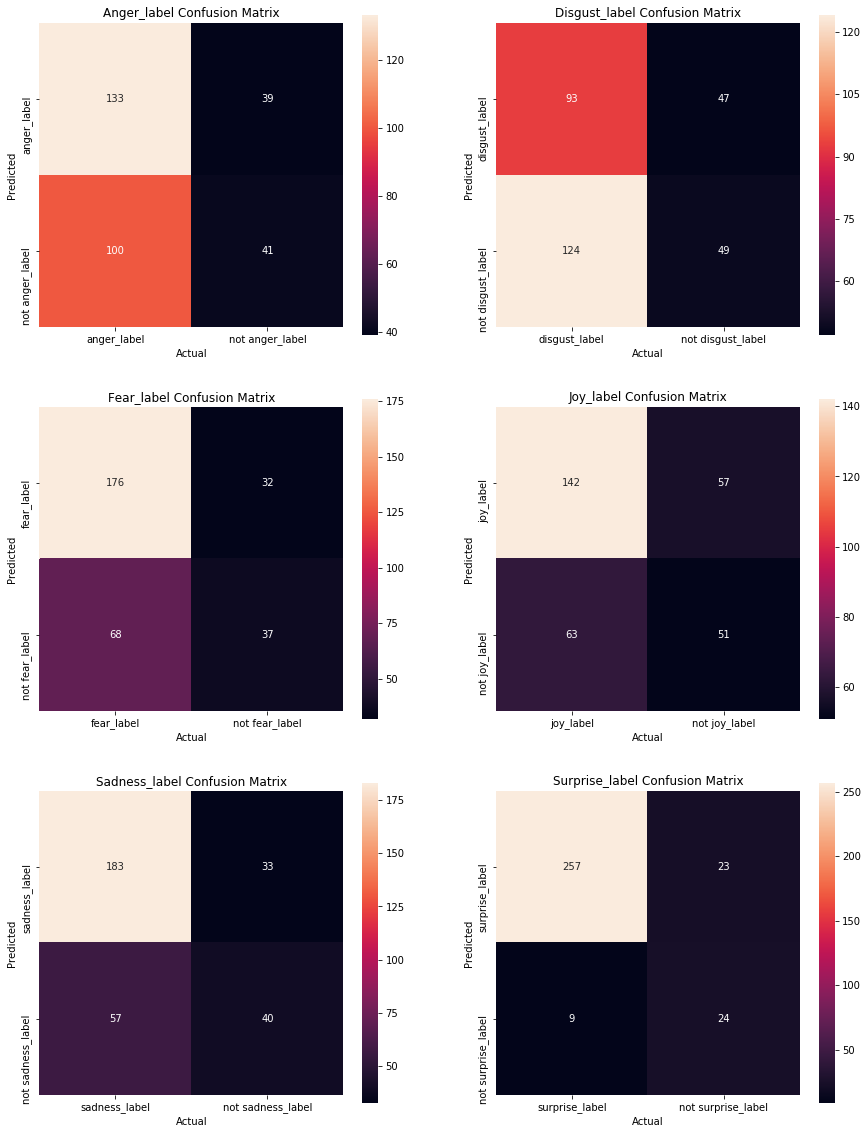

In [30]:
label_confusion_matrices(['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label'], LP_preds_df)


In [31]:
suite_of_scores(y_test, lp_test_preds.toarray())


jaccard score average: 0.691
hamming loss: 0.252
f1 macro: 0.79
log loss 31.986


## RNN for Multilabel Classification

In [32]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)
            

In [33]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(corpus_df['text']))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(corpus_df['text'])

# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=15, padding='post')


In [34]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]
        

In [35]:
X_train, X_test, y_train, y_test = train_test_split(padded_X, emotion_df[['anger_label', 'disgust_label', 'fear_label', 'joy_label', 'sadness_label', 'surprise_label']], test_size=0.25, random_state=1)

# labels multihot encoded
y_train_multihot = y_train.values
y_test_multihot = y_test.values


In [36]:
# Try adding another Dense layer and upping the nodes
# Add model checkpoint
# Add learning rate monitoring so it decays if it's not moving


model = Sequential()

callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=15, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_train, 
                    y_train_multihot,
                    epochs=30,
                    batch_size=100,
                    callbacks=callbacks,
                    class_weight=[{0: 3, 1: 1}, {0: 4, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}, {0: 1, 1: 1}],
                    validation_data=(X_test, y_test_multihot))

W0723 15:48:42.381948 4561753536 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 15:48:42.399914 4561753536 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 15:48:42.402147 4561753536 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 15:48:42.412523 4561753536 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 15:48:42.413713 4561753536 deprecation_wrapper

Train on 937 samples, validate on 313 samples
Epoch 1/30
937/937 [==============================] - 2s 2ms/step - loss: 0.6837 - acc: 0.6288 - val_loss: 0.6486 - val_acc: 0.6645
Epoch 2/30
937/937 [==============================] - 0s 436us/step - loss: 0.4981 - acc: 0.7695 - val_loss: 0.5813 - val_acc: 0.7135
Epoch 3/30
937/937 [==============================] - 0s 448us/step - loss: 0.4230 - acc: 0.8236 - val_loss: 0.5836 - val_acc: 0.7231
Epoch 4/30
937/937 [==============================] - 0s 438us/step - loss: 0.3628 - acc: 0.8689 - val_loss: 0.5522 - val_acc: 0.7370
Epoch 5/30
937/937 [==============================] - 0s 446us/step - loss: 0.3087 - acc: 0.8970 - val_loss: 0.5460 - val_acc: 0.7513
Epoch 6/30
937/937 [==============================] - 0s 463us/step - loss: 0.2664 - acc: 0.9219 - val_loss: 0.5510 - val_acc: 0.7503
Epoch 7/30
937/937 [==============================] - 0s 463us/step - loss: 0.2260 - acc: 0.9431 - val_loss: 0.5787 - val_acc: 0.7497
Epoch 8/30
937/937

313/313 [==============================] - 0s 197us/step


[0.6190713194612497, 0.7635782709517799]

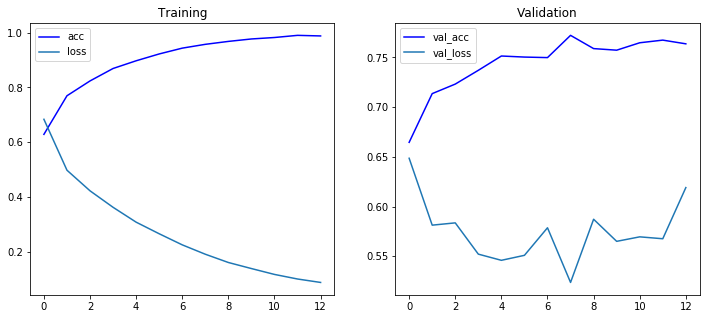

In [37]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')
plt.title("Training")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')
plt.title("Validation")
plt.legend()

model.evaluate(X_test, y_test_multihot)


In [41]:
# model.save('RNN_multiclass_emotion.h5')

RNN_preds = model.predict_on_batch(X_test)

RNN_preds_df = pd.DataFrame({"pred_anger":RNN_preds[:,0], "pred_disgust":RNN_preds[:,1], "pred_fear":RNN_preds[:,2], "pred_joy":RNN_preds[:,3], "pred_sadness":RNN_preds[:,4], "pred_surprise":RNN_preds[:,5], "anger":y_test_multihot[:,0], "disgust":y_test_multihot[:,1], "fear": y_test_multihot[:,2], "joy": y_test_multihot[:,3], "sadness": y_test_multihot[:,4], "surprise": y_test_multihot[:,5]})


anger accuracy: 0.43223443223443225
anger precision: 0.7515923566878981
anger recall 0.7468354430379747
anger f1 0.7492063492063493


disgust accuracy: 0.2956204379562044
disgust precision: 0.6639344262295082
disgust recall 0.675
disgust f1 0.6694214876033058


fear accuracy: 0.5647058823529412
fear precision: 0.8181818181818182
fear recall 0.7128712871287128
fear f1 0.761904761904762


joy accuracy: 0.604982206405694
joy precision: 0.7692307692307693
joy recall 0.8415841584158416
joy f1 0.8037825059101654


sadness accuracy: 0.6164874551971327
sadness precision: 0.8514851485148515
sadness recall 0.8349514563106796
sadness f1 0.8431372549019608


surprise accuracy: 0.8817567567567568
surprise precision: 0.8938356164383562
surprise recall 0.9388489208633094
surprise f1 0.9157894736842105




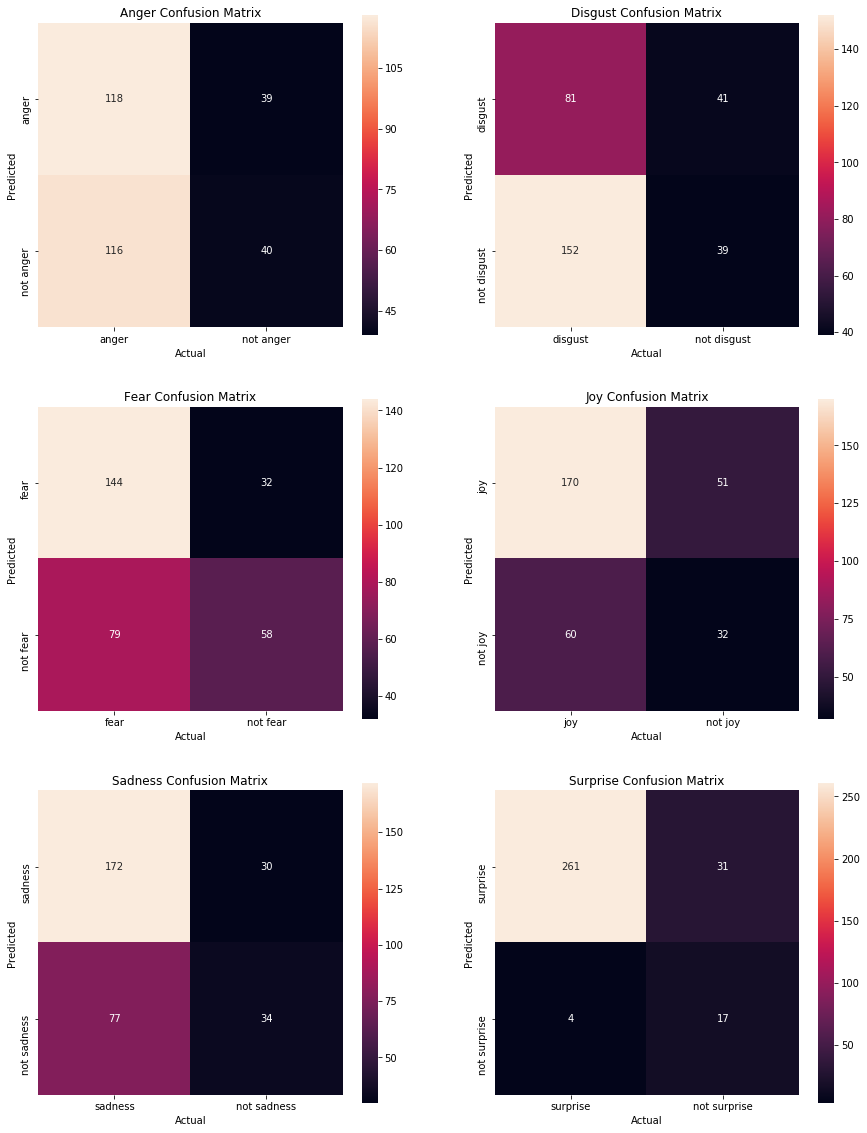

In [39]:
label_confusion_matrices(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'], RNN_preds_df, RNN=True)

In [40]:
suite_of_scores(y_test, RNN_preds>.5)


jaccard score average: 0.704
hamming loss: 0.236
f1 macro: 0.791
log loss 29.18
